In [1]:
import numpy as np
import pandas as pd
import time, sys, json, os, io, cv2, base64
from io import BytesIO
from subprocess import check_output
from pprint import pprint as pp
import pymongo
from pymongo import MongoClient
import hashlib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from random import randint
from skimage import exposure
from tqdm import tqdm_notebook
import gc
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Concatenate, SpatialDropout2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.layers.merge import add
from keras import regularizers
from keras.regularizers import l2
from keras.losses import binary_crossentropy
from keras.activations import softmax
from keras.backend import tensorflow_backend
from keras.backend import common
from keras.callbacks import LambdaCallback
import tensorflow as tf

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
path_train = '../data/train/'
path_test = '../data/test/'
train_ids = next(os.walk(path_train))[2]
test_ids = next(os.walk(path_test))[2]
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = pd.read_csv("../data/train.csv", index_col="id")

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

def insert_data(data, db, collection, check_id='id', host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    
    duplicate_result = db[collection].find(
       {check_id: data[check_id]})
    
    print('duplicate count' + str(duplicate_result.count()))
    if duplicate_result.count() == 0:
        db[collection].insert_one(data)

def set_data(db, collection, search, set_query, host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    db[collection].update(
        search,
        { '$set': set_query }
    )
        
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

def sample_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, num_sample=1000):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].aggregate([{ "$sample": { "size": num_sample }}])

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [4]:
%%time
img_size_ori = 101
img_size_target = 128

def read_resize_img(x, scale,mask=False):
    img_byte = io.BytesIO(base64.b64decode(x))
    img_np = np.array(imread(img_byte, as_gray=True))/scale
    img_np = resize(img_np,(img_size_target,img_size_target), mode='constant', preserve_range=True)
    if mask:
        img_np[img_np>0] = 1
    return img_np

train_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$ne":None}}]})
# test_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]})
test_df = sample_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]})

# train_df = train_df.loc[:20]

train_df['img'] = train_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
train_df['img_mask'] = train_df['img_mask_base64'].apply(lambda x: read_resize_img(x, 65535.0, mask=True))
train_df['img_temperal_mask'] = train_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img'] = test_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
test_df['img_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img_temperal_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))

train_df = train_df.drop('img_base64', axis=1)
train_df = train_df.drop('img_mask_base64', axis=1)
train_df = train_df.drop('ASM', axis=1)
train_df = train_df.drop('contrast', axis=1)
train_df = train_df.drop('correlation', axis=1)
train_df = train_df.drop('dissimilarity', axis=1)
train_df = train_df.drop('energy', axis=1)
train_df = train_df.drop('entropy', axis=1)
train_df = train_df.drop('homogeneity', axis=1)
train_df = train_df.drop('coverage', axis=1)
train_df = train_df.drop('coverage_class', axis=1)
test_df = test_df.drop('img_base64', axis=1)

train_df, val_df = train_test_split(train_df, test_size=0.1)

CPU times: user 15.2 s, sys: 636 ms, total: 15.8 s
Wall time: 28.3 s


In [5]:
test_df.head(1)

,ASM,contrast,correlation,coverage,coverage_class,depth,dissimilarity,energy,entropy,homogeneity,img_id,img_mask_base64,img_size,rle_mask,img,img_mask,img_temperal_mask
0,b'iVBORw0KGgoAAAANSUhEUgAAAGUAAABlCAQAAAD+deVE...,b'iVBORw0KGgoAAAANSUhEUgAAAGUAAABlCAQAAAD+deVE...,b'iVBORw0KGgoAAAANSUhEUgAAAGUAAABlCAQAAAD+deVE...,0.345652,4.0,733,b'iVBORw0KGgoAAAANSUhEUgAAAGUAAABlCAQAAAD+deVE...,b'iVBORw0KGgoAAAANSUhEUgAAAGUAAABlCAQAAAD+deVE...,b'iVBORw0KGgoAAAANSUhEUgAAAGUAAABlCAQAAAD+deVE...,b'iVBORw0KGgoAAAANSUhEUgAAAGUAAABlCAQAAAD+deVE...,4c8132dc73,b'iVBORw0KGgoAAAANSUhEUgAAAGUAAABlEAAAAAAhh65Q...,"[101, 101]",1 41 102 41 203 41 304 41 405 41 506 41 607 41...,"[[0.44072753191, 0.4903023839, 0.490848362446,...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1..."


In [6]:
def sample_df():
    # temperarly sample from df as not enough memory
    sample_rate = 0.35
    sample_rate = 1.0/sample_rate

    sample_train_df = train_df.sample(int(train_df.shape[0]/sample_rate))
    sample_val_df = val_df.sample(int(val_df.shape[0]/sample_rate))
    sample_test_df = test_df.sample(int(test_df.shape[0]/sample_rate))

    # sample_train_df = train_df.sample(int(train_df.shape[0]/1))
    # sample_val_df = val_df.sample(int(val_df.shape[0]/1))
    # sample_test_df = test_df.sample(int(test_df.shape[0]/1000))
    return sample_train_df, sample_val_df, sample_test_df

sample_train_df, sample_val_df, sample_test_df = sample_df()

In [7]:
%%time

def img_augmentation(sample_train_df, sample_val_df, sample_test_df):
    def random_crop_resize(x, crop, flip):
        x = np.fliplr(x) if flip else x
        x = x[crop[0]:-crop[1],crop[2]:-crop[3]]
        x = resize(x,(img_size_target,img_size_target), mode='constant', preserve_range=True)
        return x

    def img_augment(df):
        augment_df = pd.DataFrame()
        for index, row in tqdm_notebook(df.iterrows(),total=len(df.index)):
            # np.random.seed(0)
            crop = np.random.randint(low=1, high=10, size=4)
            flip = np.random.choice([True, False])
            aug_img = random_crop_resize(row['img'], crop, flip)
            aug_img_mask = random_crop_resize(row['img_mask'], crop, flip)
            aug_img_temperal_mask = random_crop_resize(row['img_temperal_mask'], crop, flip)

            augment_df = augment_df.append(
                {
                    'depth': row['depth'],
                    'img_id': row['img_id']+'_augment',
                    'aug_img': aug_img,
                    'aug_img_mask': aug_img_mask,
                    'aug_img_temperal_mask': aug_img_temperal_mask,
                }, ignore_index=True
            )
        return augment_df
    
    train_augment_df = img_augment(sample_train_df)
    val_augment_df = img_augment(sample_val_df)
    test_augment_df = img_augment(sample_test_df)
    
    return train_augment_df, val_augment_df, test_augment_df

train_augment_df, val_augment_df, test_augment_df = img_augmentation(sample_train_df, sample_val_df, sample_test_df)


CPU times: user 11.2 s, sys: 200 ms, total: 11.4 s
Wall time: 11.4 s


In [8]:
test_augment_df.head(1)

,aug_img,aug_img_mask,aug_img_temperal_mask,depth,img_id
0,"[[0.502855868617, 0.477867145819, 0.4329084306...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",434.0,539bbb05f8_augment


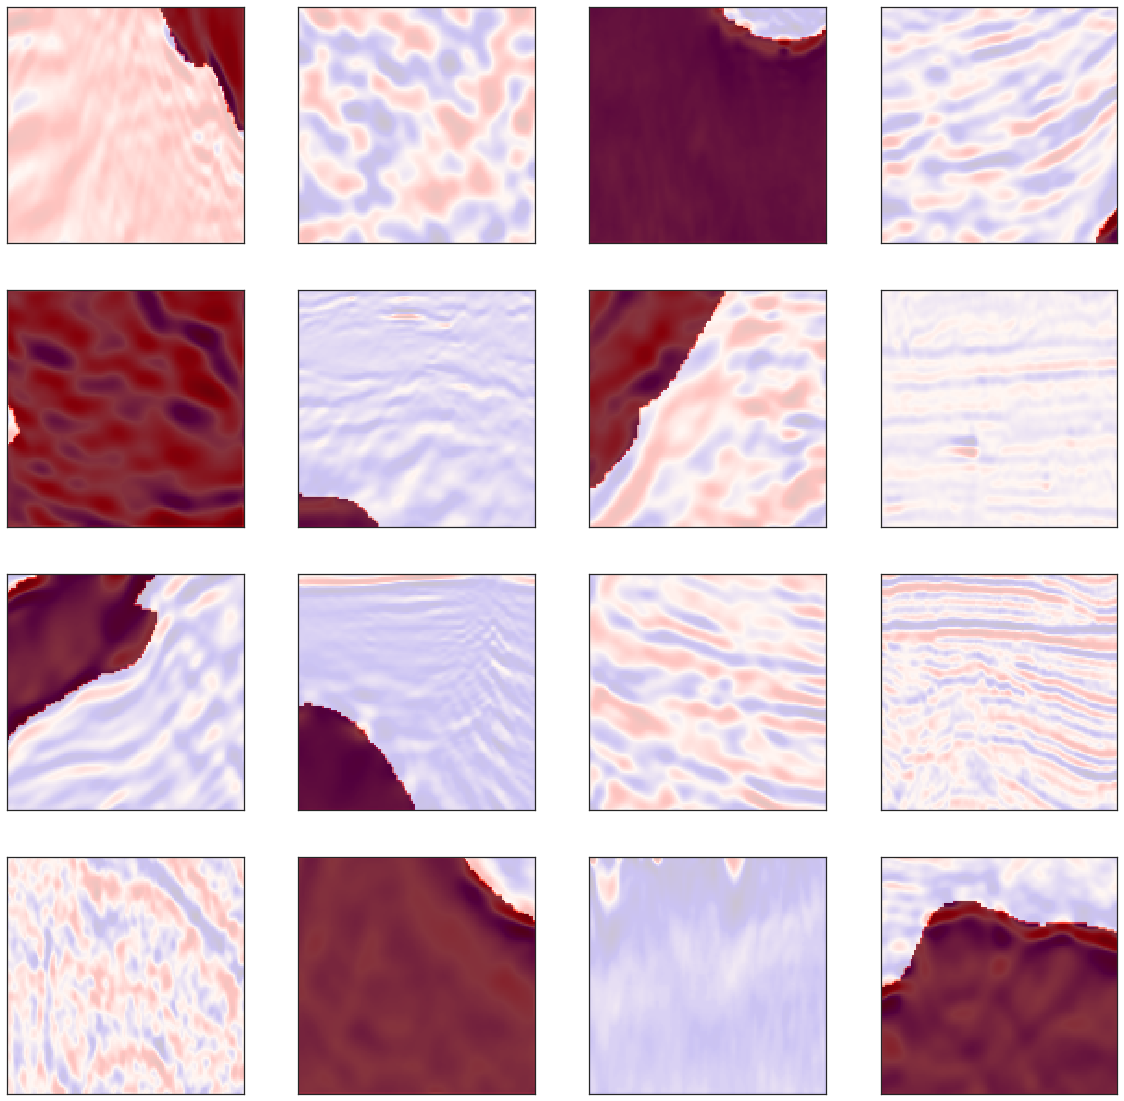

In [9]:
base_idx = 0
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(train_augment_df.index[base_idx:base_idx+int(max_images)]):
    img = train_augment_df.loc[idx].aug_img
    mask = train_augment_df.loc[idx].aug_img_mask
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
#     ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [10]:
def convert_to_np_array(train_augment_df, val_augment_df, test_augment_df):
    X_train = np.expand_dims(np.stack((np.asarray(train_augment_df['aug_img'].values.tolist()))),axis=3)
    X_valid = np.expand_dims(np.stack((np.asarray(val_augment_df['aug_img'].values.tolist()))),axis=3)
    X_test = np.expand_dims(np.stack((np.asarray(test_augment_df['aug_img'].values.tolist()))),axis=3)

    y_train = np.expand_dims(np.asarray(train_augment_df['aug_img_mask'].values.tolist()),axis=3)
    y_valid = np.expand_dims(np.asarray(val_augment_df['aug_img_mask'].values.tolist()),axis=3)
    y_test = np.expand_dims(np.asarray(test_augment_df['aug_img_mask'].values.tolist()),axis=3)

    y_temp_train = np.expand_dims(np.asarray(train_augment_df['aug_img_temperal_mask'].values.tolist()),axis=3)
    y_temp_valid = np.expand_dims(np.asarray(val_augment_df['aug_img_temperal_mask'].values.tolist()),axis=3)
    y_temp_test = np.expand_dims(np.asarray(test_augment_df['aug_img_temperal_mask'].values.tolist()),axis=3)

    y_train = np.concatenate((y_train,y_temp_train),axis=3)
    y_valid = np.concatenate((y_valid,y_temp_valid),axis=3)
    y_test = np.concatenate((y_test,y_temp_test),axis=3)

    X_train = np.concatenate((X_train,X_test),axis=0)
    y_train = np.concatenate((y_train,y_test),axis=0)
    
    return X_train, y_train, X_valid, y_valid

X_train, y_train, X_valid, y_valid = convert_to_np_array(train_augment_df, val_augment_df, test_augment_df)

In [11]:
# tensorflow session setting
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.Session(config=tf_config))

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def keras_binary_crossentropy(target, output, from_logits=False):
        # Note: tf.nn.sigmoid_cross_entropy_with_logits
        # expects logits, Keras expects probabilities.
        if not from_logits:
            # transform back to logits
            _epsilon = tensorflow_backend._to_tensor(common.epsilon(), output.dtype.base_dtype)
            output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
            output = tf.log(output / (1 - output))
        
        # this will return a tensor
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target,
                                                       logits=output)

In [12]:
from debug import _debug_func

# MSE between current and temporal outputs
def temperal_mse_loss(y_true, y_pred):
    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
#         y_temperal = _debug_func(y_temperal,"y_temperal")

    # count temperal size which has value (not -1)
    temperal_size=tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_temperal, [1,2,3]), -1), tf.float32))

    # generate filter using y_temperal
    temperal_filter = tf.cast(tf.not_equal(y_temperal, -1), tf.float32)

    # filter out MSE if temperal = -1
    quad_diff = K.sum(temperal_filter*((y_pred - y_temperal) ** 2))

    quad_diff = quad_diff / (temperal_size*128*128+1e-15)

    return quad_diff

def masked_crossentropy(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])

    # count mask size
    mask_size=tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32))

    # generate mask filter as test doesn't have mask (-1)
    mask_filter = tf.cast(tf.not_equal(y_mask, -1), tf.float32)

    bce_loss = keras_binary_crossentropy(y_mask, y_pred)

    dice_loss_ = dice_loss(mask_filter*y_mask, mask_filter*y_pred)

    bce_dice_loss = dice_loss_ + (K.sum(mask_filter*bce_loss) / (mask_size*128*128+1e-15))

    return bce_dice_loss

def mask_mean_iou(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
    mask_filter = tf.cast(tf.not_equal(y_mask, -1), tf.float32)
    mask_mean_iou = mean_iou(mask_filter*y_mask, mask_filter*y_pred)
    return mask_mean_iou

def temperal_mean_iou(y_true, y_pred):
    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
    temperal_filter = tf.cast(tf.not_equal(y_temperal, -1), tf.float32)
    temperal_mean_iou = mean_iou(temperal_filter*y_temperal, temperal_filter*y_pred)
    return temperal_mean_iou

def temporal_loss(y_true, y_pred):
    sup_loss = masked_crossentropy(y_true, y_pred)
    unsup_loss = temperal_mse_loss(y_true, y_pred)
    w = 20
    
    return sup_loss + w * unsup_loss

In [13]:
def calculate_test_temperal_mask():
    global model_train, test_df
    X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
    predict_test = model_train.predict(X_test,batch_size=16, verbose=1)
    predict_test = np.squeeze(predict_test)
    
    for index, row in tqdm_notebook(test_df.iterrows(),total=len(test_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_test[index]
        if(np.mean(img_temperal_mask) == -1):
            test_df.at[index,'img_temperal_mask'] = predict
        else:
            test_df.at[index,'img_temperal_mask'] = (img_temperal_mask + predict)/2 

def build_dataset(epoch):
    calculate_test_temperal_mask()
    
    global model_train, X_train, y_train, X_valid, y_valid, train_augment_df, val_augment_df, test_augment_df
    del X_train, X_valid, y_train, y_valid
    del train_augment_df, val_augment_df, test_augment_df
    gc.collect()
    
    sample_train_df, sample_val_df, sample_test_df = sample_df()
    train_augment_df, val_augment_df, test_augment_df = img_augmentation(sample_train_df, sample_val_df, sample_test_df)
    X_train, y_train, X_valid, y_valid = convert_to_np_array(train_augment_df, val_augment_df, test_augment_df)
    
build_dataset_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: build_dataset(epoch)
)

In [14]:
def conv_block(m, dim, acti, bn, res, do=0, training=None):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = SpatialDropout2D(do/2.0)(n, training=training) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    n = Concatenate()([m, n]) if res else n
    n = SpatialDropout2D(do)(n, training=training) if do else n
    return n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res,training=None):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res, training=training)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res, training=training)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res, training=training)
    else:
        m = conv_block(m, dim, acti, bn, res, do, training=training)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=5, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=True, training=None):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual, training=training)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

# used for training unsuperivsed, that keep dropout
model_train = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.6, training=True)

# used for predict, no dropout
model_test = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.6, training=None)
# model.compile(loss='binary_crossentropy', optimizer="adam", metrics=[mean_iou,"accuracy"])
# model_train.compile(loss=bce_dice_loss, optimizer="adam", metrics=[mean_iou,"accuracy"])
model_train.compile(loss=temporal_loss, optimizer="adam", metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [15]:
%%time
epochs = 10
batch_size = 32
callbacks = [
    EarlyStopping(patience=10, verbose=1, monitor="val_mask_mean_iou", mode="max"),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet-resnet.h5', verbose=1, save_best_only=True, monitor="val_mask_mean_iou", mode="max"),
    build_dataset_callback
]

history = model_train.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

# del X_train, X_valid, y_train, y_valid
# del train_augment_df, val_augment_df, test_augment_df
# gc.collect()

Train on 1610 samples, validate on 140 samples
Epoch 1/10
1610/1610 [==============================] - 43s 26ms/step - loss: 0.8925 - masked_crossentropy: 0.8925 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.5499 - temperal_mean_iou: 0.9801 - val_loss: 1.6928 - val_masked_crossentropy: 1.6928 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6236 - val_temperal_mean_iou: 1.0000

Epoch 00001: val_mask_mean_iou improved from -inf to 0.62357, saving model to model-unet-resnet.h5
1000/1000 [==============================] - 8s 8ms/step



Epoch 2/10
1610/1610 [==============================] - 25s 15ms/step - loss: 0.6791 - masked_crossentropy: 0.6791 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6359 - temperal_mean_iou: 1.0000 - val_loss: 1.1930 - val_masked_crossentropy: 1.1930 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6549 - val_temperal_mean_iou: 1.0000

Epoch 00002: val_mask_mean_iou improved from 0.62357 to 0.65491, saving model to model-unet-resnet.h5
1000/1000 [==============================] - 6s 6ms/step



Epoch 3/10
1610/1610 [==============================] - 24s 15ms/step - loss: 0.6678 - masked_crossentropy: 0.6678 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6614 - temperal_mean_iou: 1.0000 - val_loss: 1.3199 - val_masked_crossentropy: 1.3199 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6692 - val_temperal_mean_iou: 1.0000

Epoch 00003: val_mask_mean_iou improved from 0.65491 to 0.66918, saving model to model-unet-resnet.h5
1000/1000 [==============================] - 6s 6ms/step



Epoch 4/10
1610/1610 [==============================] - 24s 15ms/step - loss: 0.6094 - masked_crossentropy: 0.6094 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6706 - temperal_mean_iou: 1.0000 - val_loss: 0.7656 - val_masked_crossentropy: 0.7656 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6810 - val_temperal_mean_iou: 1.0000

Epoch 00004: val_mask_mean_iou improved from 0.66918 to 0.68100, saving model to model-unet-resnet.h5
1000/1000 [==============================] - 6s 6ms/step



Epoch 5/10
1610/1610 [==============================] - 24s 15ms/step - loss: 0.5765 - masked_crossentropy: 0.5765 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6888 - temperal_mean_iou: 1.0000 - val_loss: 1.5748 - val_masked_crossentropy: 1.5748 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6937 - val_temperal_mean_iou: 1.0000

Epoch 00005: val_mask_mean_iou improved from 0.68100 to 0.69373, saving model to model-unet-resnet.h5
1000/1000 [==============================] - 6s 6ms/step



Epoch 6/10
1610/1610 [==============================] - 24s 15ms/step - loss: 0.5097 - masked_crossentropy: 0.5097 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6968 - temperal_mean_iou: 1.0000 - val_loss: 0.5432 - val_masked_crossentropy: 0.5432 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7033 - val_temperal_mean_iou: 1.0000

Epoch 00006: val_mask_mean_iou improved from 0.69373 to 0.70333, saving model to model-unet-resnet.h5
1000/1000 [==============================] - 6s 6ms/step



Epoch 7/10
1610/1610 [==============================] - 24s 15ms/step - loss: 0.4793 - masked_crossentropy: 0.4793 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7096 - temperal_mean_iou: 1.0000 - val_loss: 0.6201 - val_masked_crossentropy: 0.6201 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7149 - val_temperal_mean_iou: 1.0000

Epoch 00007: val_mask_mean_iou improved from 0.70333 to 0.71487, saving model to model-unet-resnet.h5
1000/1000 [==============================] - 6s 6ms/step



Epoch 8/10
1610/1610 [==============================] - 24s 15ms/step - loss: 0.4681 - masked_crossentropy: 0.4681 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7199 - temperal_mean_iou: 1.0000 - val_loss: 0.6554 - val_masked_crossentropy: 0.6554 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7236 - val_temperal_mean_iou: 1.0000

Epoch 00008: val_mask_mean_iou improved from 0.71487 to 0.72363, saving model to model-unet-resnet.h5
1000/1000 [==============================] - 6s 6ms/step



Epoch 9/10
1610/1610 [==============================] - 24s 15ms/step - loss: 0.4518 - masked_crossentropy: 0.4518 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7285 - temperal_mean_iou: 1.0000 - val_loss: 0.7868 - val_masked_crossentropy: 0.7868 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7315 - val_temperal_mean_iou: 1.0000

Epoch 00009: val_mask_mean_iou improved from 0.72363 to 0.73146, saving model to model-unet-resnet.h5
1000/1000 [==============================] - 6s 6ms/step



Epoch 10/10
1610/1610 [==============================] - 24s 15ms/step - loss: 0.4244 - masked_crossentropy: 0.4244 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7349 - temperal_mean_iou: 1.0000 - val_loss: 0.5390 - val_masked_crossentropy: 0.5390 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7383 - val_temperal_mean_iou: 1.0000

Epoch 00010: val_mask_mean_iou improved from 0.73146 to 0.73833, saving model to model-unet-resnet.h5
1000/1000 [==============================] - 6s 6ms/step



CPU times: user 7min 43s, sys: 46.8 s, total: 8min 30s
Wall time: 7min 35s


In [ ]:
for i in range(10):
    sample_train_df, sample_val_df, sample_test_df = sample_df()
    train_augment_df, val_augment_df, test_augment_df = img_augmentation(sample_train_df, sample_val_df, sample_test_df)
    X_train, y_train, X_valid, y_valid = convert_to_np_array(train_augment_df, val_augment_df, test_augment_df)

    history = model_train.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks,
                        validation_data=(X_valid, y_valid))
    calculate_test_temperal_mask()

In [ ]:
fig, (ax_loss, ax_acc, ax_iou) = plt.subplots(1, 3, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mask_mean_iou"], label="Train mask iou")
ax_acc.plot(history.epoch, history.history["val_mask_mean_iou"], label="Validation mask iou")
ax_iou.plot(history.epoch, history.history["temperal_mean_iou"], label="Train temperal iou")
ax_iou.plot(history.epoch, history.history["val_temperal_mean_iou"], label="Validation temperal iou")

In [ ]:
# model = load_model("./model-unet-resnet.h5", custom_objects={'mean_iou':mean_iou})

X_valid = np.expand_dims(np.stack((np.asarray(val_df['img'].values.tolist()))),axis=3)
y_valid = np.expand_dims(np.asarray(val_df['img_mask'].values.tolist()),axis=3)
preds_valid = model_train.predict(X_valid, batch_size=32, verbose=1)

In [ ]:
# plot some validate result
base_idx = 10
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(val_df.index[base_idx:base_idx+int(max_images/2)]):
    img = val_df.iloc[i].img
    mask = val_df.iloc[i].img_mask
    pred = preds_valid[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(pred, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]);ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [ ]:
# plot some temperal mask on test results
base_idx = 0
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(test_df.index[base_idx:base_idx+int(max_images)]):
    img = test_df.loc[idx].img
    mask = test_df.loc[idx].img_temperal_mask
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
#     ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [14]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch],print_table=False)
        metric.append(value)
    return np.mean(metric)


from math import sqrt
from joblib import Parallel, delayed
import multiprocessing  
from tqdm import tqdm  

thresholds = np.linspace(0, 1, 20)
# result = Parallel(n_jobs=2)(io_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds))
# ious = np.array([iou_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

threshold_best: 0.6842105263157894, iou_best: 0.8073125


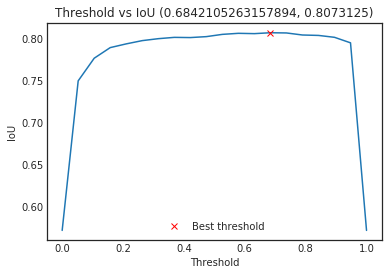

In [15]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(f'threshold_best: {threshold_best}, iou_best: {iou_best}')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()